Final part.. lets see if we can predict musicians who are 'successful' (i.e. high in popularity score and followers) 

In [1]:
import pandas as pd
import numpy as np
from utils import MusicDataLoader
from collections import Counter

loader = MusicDataLoader()
mus_nodes = loader.get_features(n_release_bins=100)
mus_nodes.network_rank = mus_nodes.network_rank.fillna(0)


In [2]:
def test(model,X_train,X_test,y_train,y_test):
    print('================')
    print(type(model))

    model.fit(X_train,y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f'training accuracy: {f1_score(y_train,pred_train)}')
    print(confusion_matrix(y_train,pred_train))
    
    print(f'testing accuracy: {f1_score(y_test,pred_test)}')
    print(confusion_matrix(y_test,pred_test))

# iterative approach. instead of using network as input, let's first see if we can divide the network into nodes and then do it.
# lets featurize the dataset first
def featurize_mus(mus_nodes,target = 'popularity',thresh=50):
    scalar_features = [
        'followers', 'popularity', 'network_rank','in_edges','out_edges','num_release']
    scalar_features = list(filter(lambda x: x!=target, scalar_features))
    # first get all genres and create a base mask
    allgenres = list(set([g for gg in mus_nodes.genres.values.tolist() for g in gg]))
    get_genre_mask = lambda glist: [int(g in glist) for g in allgenres]

    # features = pd.DataFrame(
    #     mus_nodes.genres.apply(get_genre_mask).values.tolist(),
    #     columns=[g for g in allgenres]
    # )
    features=pd.DataFrame()
    features[scalar_features] = mus_nodes[scalar_features]

    firsts = pd.to_datetime(mus_nodes.first_release)
    lasts = pd.to_datetime(mus_nodes.last_release)
    features['first_release'] = firsts.view(int)
    features['last_release'] = lasts.view(int)
    features['career length'] = (lasts-firsts).view(int)
    
    return (mus_nodes[target].values >= thresh).astype(int),features


In [3]:
thres = 80

(mus_nodes.popularity > thres).sum() / len(mus_nodes)

0.022626888802789617

<class 'xgboost.sklearn.XGBClassifier'>
[19:34:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training accuracy: 0.749003984063745
[[10010    33]
 [   93   188]]
testing accuracy: 0.7008547008547009
[[2505    8]
 [  27   41]]


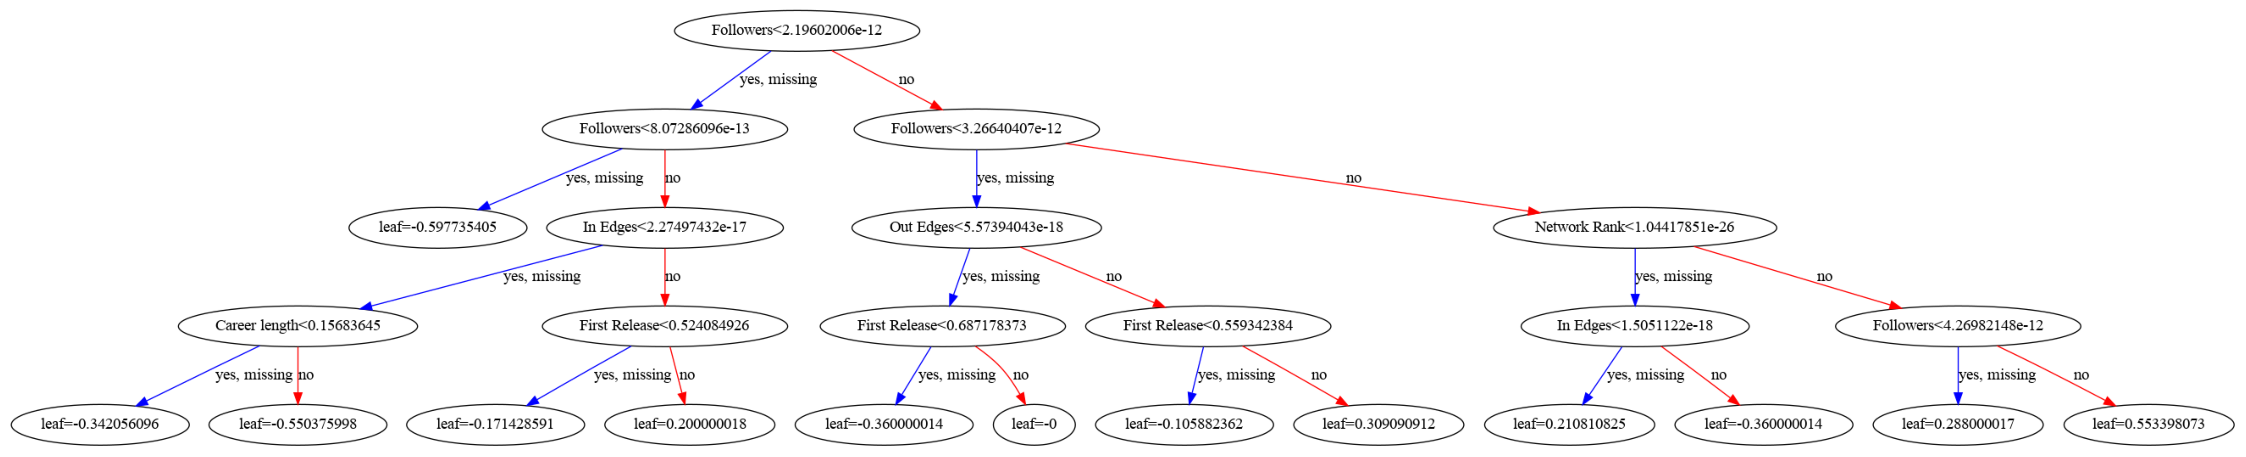

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from xgboost import XGBClassifier,plot_tree
import matplotlib.pyplot as plt

y,X_df = featurize_mus(mus_nodes,'popularity',80)
cols = [' '.join([w.capitalize() for w in c.split('_')]) for c in X_df.columns]

Xvals = Normalizer().fit_transform(X_df.values)
X_train, X_test, y_train, y_test = train_test_split(Xvals, y, test_size=0.2, random_state=0)
X_train,X_test = pd.DataFrame(X_train,columns=cols),pd.DataFrame(X_test,columns=cols)

open('feat_for_xgb.txt','w')
feats = pd.DataFrame()
feats[0] = X_df.columns
feats[1] = 'i'

xg = XGBClassifier(
    # eta=0.5,
    random_state=0,
    max_depth=3,
    # reg_lambda=2,
    # reg_alpha=2,
    use_label_encoder=False,
    # verbosity=0,
    n_estimators=1,
)
test(xg,X_train,X_test,y_train,y_test)

# feats = pd.DataFrame()
# feats[0] = [' '.join([w.capitalize() for w in c.split('_')]) for c in X_df.columns]
# feats[1] = 'i'

# feats.to_csv('feats_for_xgb.txt',sep='\t',header=False)

fig,ax = plt.subplots(figsize=(40,20))
plot_tree(xg,ax = ax,)
fig.get_figure().savefig('pics/learned_xgboost_pop.png')


#### Ok, we can learn a predictor for popularity. what about predictor for follower count?

In [27]:
thres = 1e5

(mus_nodes.followers > thres).sum() / len(mus_nodes)

0.36412243316543974

<class 'xgboost.sklearn.XGBClassifier'>
[19:36:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training accuracy: 0.8147966080865183
[[5502 1021]
 [ 486 3315]]
testing accuracy: 0.7757449032932565
[[1410  273]
 [ 156  742]]


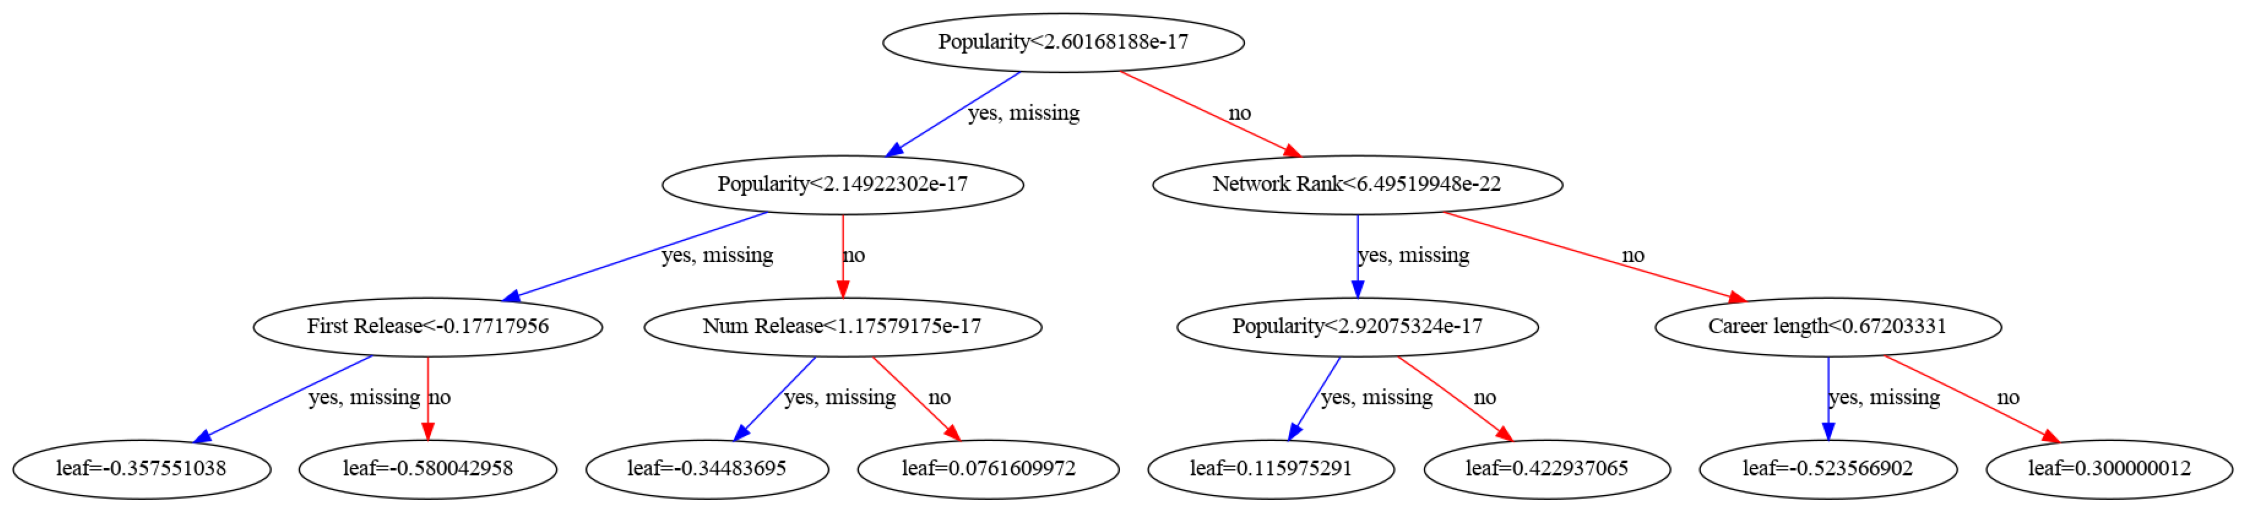

In [31]:
y,X_df = featurize_mus(mus_nodes,'followers',1e5)
cols = [' '.join([w.capitalize() for w in c.split('_')]) for c in X_df.columns]

Xvals = Normalizer().fit_transform(X_df.values)
X_train, X_test, y_train, y_test = train_test_split(Xvals, y, test_size=0.2, random_state=0)
X_train,X_test = pd.DataFrame(X_train,columns=cols),pd.DataFrame(X_test,columns=cols)

open('feat_for_xgb.txt','w')
feats = pd.DataFrame()
feats[0] = X_df.columns
feats[1] = 'i'

xg = XGBClassifier(
    # eta=0.5,
    random_state=0,
    max_depth=3,
    # reg_lambda=1,
    # reg_alpha=2,
    use_label_encoder=False,
    # verbosity=0,
    n_estimators=1,
)
test(xg,X_train,X_test,y_train,y_test)

# feats = pd.DataFrame()
# feats[0] = [' '.join([w.capitalize() for w in c.split('_')]) for c in X_df.columns]
# feats[1] = 'i'

# feats.to_csv('feats_for_xgb.txt',sep='\t',header=False)

fig,ax = plt.subplots(figsize=(40,20))
plot_tree(xg,ax = ax,)
fig.get_figure().savefig('pics/learned_xgboost_fol.png')


#### We already know we like xgboost, but let's do a comparison

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
    
for thresh in range(50,71,5):
    y,X_df = featurize_mus(mus_nodes,'popularity',thresh)
    cols = [' '.join([w.capitalize() for w in c.split('_')]) for c in X_df.columns]

    Xvals = Normalizer().fit_transform(X_df.values)
    X_train, X_test, y_train, y_test = train_test_split(Xvals, y, test_size=0.2, random_state=0)
    X_train,X_test = pd.DataFrame(X_train,columns=cols),pd.DataFrame(X_test,columns=cols)
    
    lr = LogisticRegression(
        random_state=0
    )
    test(lr,X_train.values,X_test.values,y_train,y_test)
    
    svc = LinearSVC(
        random_state=0
    )
    test(svc,X_train.values,X_test.values,y_train,y_test)
    
    rf = RandomForestClassifier(
        random_state=0
    )
    test(rf,X_train.values,X_test.values,y_train,y_test)

    xg = XGBClassifier(n_estimators=1,random_state=0)
    test(xg,X_train,X_test,y_train,y_test)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
training accuracy: 0.21599453178400546
[[5104  561]
 [4027  632]]
testing accuracy: 0.1741038771031456
[[1333  137]
 [ 992  119]]
<class 'sklearn.svm._classes.LinearSVC'>
training accuracy: 0.24560271098918832
[[4888  777]
 [3898  761]]
testing accuracy: 0.2302947224126114
[[1290  180]
 [ 943  168]]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
training accuracy: 0.8970107426436245
[[5601   64]
 [ 818 3841]]
testing accuracy: 0.45664739884393063
[[979 491]
 [637 474]]
<class 'xgboost.sklearn.XGBClassifier'>
training accuracy: 0.860516442286471
[[5161  504]
 [ 760 3899]]
testing accuracy: 0.8313364055299538
[[1313  157]
 [ 209  902]]
<class 'sklearn.linear_model._logistic.LogisticRegression'>
training accuracy: 0.0
[[6699    0]
 [3625    0]]
testing accuracy: 0.0
[[1725    0]
 [ 856    0]]
<class 'sklearn.svm._classes.LinearSVC'>


/home/inwon/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 0.0
[[6699    0]
 [3625    0]]
testing accuracy: 0.0
[[1725    0]
 [ 856    0]]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
training accuracy: 0.904569288389513
[[6668   31]
 [ 606 3019]]
testing accuracy: 0.3786764705882353
[[1258  467]
 [ 547  309]]
<class 'xgboost.sklearn.XGBClassifier'>
training accuracy: 0.8529037727850783
[[6265  434]
 [ 607 3018]]
testing accuracy: 0.8185053380782918
[[1585  140]
 [ 166  690]]
<class 'sklearn.linear_model._logistic.LogisticRegression'>
training accuracy: 0.0
[[7613    0]
 [2711    0]]
testing accuracy: 0.0
[[1948    0]
 [ 633    0]]
<class 'sklearn.svm._classes.LinearSVC'>


/home/inwon/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 0.0
[[7613    0]
 [2711    0]]
testing accuracy: 0.0
[[1948    0]
 [ 633    0]]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
training accuracy: 0.9142743221690589
[[7601   12]
 [ 418 2293]]
testing accuracy: 0.3048084759576202
[[1541  407]
 [ 446  187]]
<class 'xgboost.sklearn.XGBClassifier'>
training accuracy: 0.824067022086824
[[7236  377]
 [ 547 2164]]
testing accuracy: 0.7993579454253612
[[1833  115]
 [ 135  498]]
<class 'sklearn.linear_model._logistic.LogisticRegression'>
training accuracy: 0.0
[[8475    0]
 [1849    0]]
testing accuracy: 0.0
[[2150    0]
 [ 431    0]]
<class 'sklearn.svm._classes.LinearSVC'>


/home/inwon/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 0.0
[[8475    0]
 [1849    0]]
testing accuracy: 0.0
[[2150    0]
 [ 431    0]]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
training accuracy: 0.9212895730467616
[[8467    8]
 [ 263 1586]]
testing accuracy: 0.22039859320046892
[[1822  328]
 [ 337   94]]
<class 'xgboost.sklearn.XGBClassifier'>


/home/inwon/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 0.7810721772985924
[[8289  186]
 [ 545 1304]]
testing accuracy: 0.7151979565772669
[[2078   72]
 [ 151  280]]
<class 'sklearn.linear_model._logistic.LogisticRegression'>
training accuracy: 0.0
[[9275    0]
 [1049    0]]
testing accuracy: 0.0
[[2339    0]
 [ 242    0]]
<class 'sklearn.svm._classes.LinearSVC'>
training accuracy: 0.0
[[9275    0]
 [1049    0]]
testing accuracy: 0.0
[[2339    0]
 [ 242    0]]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
training accuracy: 0.928644240570846
[[9273    2]
 [ 138  911]]
testing accuracy: 0.14634146341463414
[[2125  214]
 [ 206   36]]
<class 'xgboost.sklearn.XGBClassifier'>
training accuracy: 0.8002038735983691
[[9147  128]
 [ 264  785]]
testing accuracy: 0.7346938775510203
[[2302   37]
 [  80  162]]


/home/inwon/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
